<a href="https://colab.research.google.com/github/bombaybrew/colab_experiments/blob/master/quickdraw_generator_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

REFERENCE:

https://colab.research.google.com/github/zaidalyafeai/zaidalyafeai.github.io/blob/master/sketcher/Sketcher.ipynb
https://github.com/googlecreativelab/quickdraw-dataset

In [3]:
# !gcloud auth login
# !gcloud config set project 'upheld-quanta-284618'

In [2]:
!gsutil cp gs://ml_workspace/quick_draw/qd_20k_split.tar.gz .

Copying gs://ml_workspace/quick_draw/qd_20k_split.tar.gz...
| [1 files][921.5 MiB/921.5 MiB]   65.2 MiB/s                                   
Operation completed over 1 objects/921.5 MiB.                                    


In [5]:
# !tar -xzf qd_20k_split.tar.gz 
# !rm qd_20k_split.tar.gz
# !ls -lah data_processed
# !mkdir data
# !unzip data.zip
# !rm data.zip

In [81]:
# IMPORTS

import os
import glob
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import metrics
import gc

from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# classes = ['airplane', 'apple', 'ant', 'axe']
classes = ['airplane','apple','ant','axe','banana','baseball','bee','beach','bird','book','bucket','bus','butterfly','cactus','cake','cannon','car','carrot','castle',
            'cat','chair','church','circle','clock','cloud','computer','cookie','cow','crab','crayon','cup','dolphin','donut','door','dragon','diamond','drums','duck',
            'ear','elephant','envelope','eraser','eye','face','fan','finger','fish','flower','frog','garden','grapes','grass','guitar','hammer','hand','hat','helmet',
            'horse','house','hospital','jail','kangaroo','knife','laptop','leg','lion','lollipop','map','microwave','monkey','moon','mountain','mouse','mug','nail',
            'nose','onion','owl','panda','parachute','parrot','passport','peanut','pencil','piano','pig','pizza','potato','rabbit','radio','rain','rainbow','river',
            'sandwich','saw','sun','shark','shoe','skull','snail','snowflake','spider','square','stairs','star','stove','strawberry','table','teapot','television','tent',
            'toilet','toothbrush','toothpaste','train','triangle','truck','umbrella','whale','zebra']

In [ ]:
# files = glob.iglob("data/*.npy")
# file = next(files)

# data = np.load(file)
# np.random.shuffle(data)
# data = data[:10000, :]
# data.shape

# np.full(data.shape[0], 1)

In [82]:
from sklearn.utils import shuffle

image_size = 28

def data_gen():

  for batch in range(14):
    print('processing batch: ' + str(batch))
    x = np.empty([0, 784])
    y = np.empty([0]) 

    for index, class_label in enumerate(classes): 
      class_file = 'data_processed/'+str(batch)+'/'+class_label+'.npy'
      print('processing file: ' + class_file + ' - ' + str(index))
      data = np.load(class_file)
      labels = np.full(data.shape[0], index)
      x = np.concatenate((x, data), axis=0)
      y = np.append(y, labels)

    x, y = shuffle(x, y)

    x = x/255.0
    y = keras.utils.to_categorical(y, len(classes))

    x = x.reshape(x.shape[0], image_size, image_size, 1) #.astype('float16')
    
    print('---------- Loading complete')
    yield x, y

def val_test_data():

  print('processing val and test data')
  x = np.empty([0, 784])
  y = np.empty([0])

  for index, class_label in enumerate(classes):
    class_file = 'data_processed/14/'+class_label+'.npy'
    data = np.load(class_file)
    labels = np.full(data.shape[0], index)
    x = np.concatenate((x, data), axis=0)
    y = np.append(y, labels)
  x = x/255.0
  x = x.reshape(x.shape[0], image_size, image_size, 1) #.astype('float16')
  y = keras.utils.to_categorical(y, len(classes))
  print('Done processing')
  return x, y

train_gen = data_gen()

In [83]:
# x_train, y_train = next(train_gen)
x_test, y_test = val_test_data()

processing val and test data
Done processing


airplane


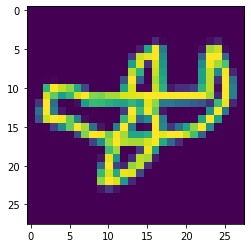

In [44]:
from random import randint
def visualise_random(x, y):

  idx = randint(0, len(x))
  plt.imshow(x[idx].reshape(28,28))
  print(classes[y[idx].tolist().index(1)])
  # print(classes[int(y_train[idx])])
  # print(y_train[idx].tolist().index(1))
  # print(x[idx].reshape(28,28))

visualise_random(x_test, y_test)
# x_train[0].reshape(28,28)

In [ ]:
print(x[1999])

[1. 0.]


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_train.nbytes/1024/1024)

(60000, 28, 28, 1)
(60000, 120)
358.88671875


processing val and test data
Done processing


In [38]:
print(x_test.shape)
print(y_test.shape)

(8000, 28, 28, 1)
(8000, 4)


In [84]:
from keras.callbacks import EarlyStopping

def lr_scheduler(epoch, lr):
  print(epoch)
  if epoch > 2:
    lr = 0.0001
    return lr
  return lr

def print_metric(model):

  score = model.evaluate(x_test, y_test, verbose=1)
  print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))
  print('----------')

  y_pred = model.predict(x_test, verbose=2)
  # y_pred = (y_pred > 0.5 ? 1 : 0)
  y_pred_argmax = np.argmax(y_pred, axis=1)
  y_test_argmax = np.argmax(y_test, axis=1)
  print(metrics.classification_report(y_test_argmax, y_pred_argmax))
  print('----------')
  print('HammingLoss: ', metrics.hamming_loss(y_test_argmax, y_pred_argmax))

def run_exp(model, x_train, y_train, epoch=8, batch_size=256):
  # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
  lr_callback = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
  model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size=256, epochs=10, callbacks=[lr_callback], verbose=1)
  print_metric(model)
  return model

def run_exp_gen(model, epoch=14, batch_size=256):
  model.fit(train_gen, validation_data=(x_val, y_val), steps_per_epoch=16, epochs=epoch, verbose=1)
  print_metric(model)
  return model


In [60]:
def get_simple_cnn(num_classes):
  activation = 'elu'

  model = keras.Sequential(name="vgg_bn_reg_seq")
  model.add(layers.Convolution2D(16, (3, 3), name='c2d_11', input_shape=(28, 28, 1), padding='same', activation=activation))
  model.add(layers.Convolution2D(16, (3, 3), name='c2d_12', padding='same', activation=activation))
  model.add(layers.Convolution2D(16, (3, 3), name='c2d_13', padding='same', activation=activation))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.BatchNormalization())
  model.add(layers.Convolution2D(32, (3, 3), name='c2d_21', padding='same', activation=activation))
  model.add(layers.Convolution2D(32, (3, 3), name='c2d_22', padding='same', activation=activation))
  model.add(layers.Convolution2D(32, (3, 3), name='c2d_23', padding='same', activation=activation))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.BatchNormalization())
  model.add(layers.Convolution2D(64, (3, 3), name='c2d_31', padding='same', activation=activation))
  model.add(layers.Convolution2D(64, (3, 3), name='c2d_32', padding='same', activation=activation))
  model.add(layers.Convolution2D(64, (3, 3), name='c2d_33', padding='same', activation=activation))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(256, name='d1', activation=activation))
  model.add(layers.Dense(256, name='d2', activation=activation))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(num_classes, name='softmax', activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

  print(model.summary())
  return model

model = get_simple_cnn(120)

Model: "vgg_bn_reg_seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c2d_11 (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
c2d_12 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
c2d_13 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
c2d_21 (Conv2D)              (None, 14, 14, 32)     

In [85]:
# x_train, y_train = next(train_gen)
model = get_simple_cnn(120)

for (x_train, y_train) in train_gen:
  model = run_exp(model, x_train, y_train)
  gc.collect()

Model: "vgg_bn_reg_seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c2d_11 (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
c2d_12 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
c2d_13 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
c2d_21 (Conv2D)              (None, 14, 14, 32)     

In [53]:
def get_vgg_bn_reg_seq(num_classes):

  activation = 'elu'

  model = keras.Sequential(name="vgg_bn_reg_seq")
  model.add(layers.Convolution2D(16, (3, 3), name='c2d_11', input_shape=(28, 28, 1), padding='same', activation=activation))
  model.add(layers.Convolution2D(16, (3, 3), name='c2d_12', padding='same', activation=activation))
  model.add(layers.Convolution2D(16, (3, 3), name='c2d_13', padding='same', activation=activation))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.BatchNormalization())
  model.add(layers.Convolution2D(32, (3, 3), name='c2d_21', padding='same', activation=activation))
  model.add(layers.Convolution2D(32, (3, 3), name='c2d_22', padding='same', activation=activation))
  model.add(layers.Convolution2D(32, (3, 3), name='c2d_23', padding='same', activation=activation))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.BatchNormalization())
  model.add(layers.Convolution2D(64, (3, 3), name='c2d_31', padding='same', activation=activation))
  model.add(layers.Convolution2D(64, (3, 3), name='c2d_32', padding='same', activation=activation))
  model.add(layers.Convolution2D(64, (3, 3), name='c2d_33', padding='same', activation=activation))
  model.add(layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Flatten())
  model.add(layers.BatchNormalization())
  model.add(layers.Dense(256, name='d1', activation=activation))
  model.add(layers.Dense(256, name='d2', activation=activation))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(num_classes, name='softmax', activation='softmax'))
  
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

  print(model.summary())
  return model

model = run_exp(get_vgg_bn_reg_seq(120))

Model: "vgg_bn_reg_seq"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
c2d_11 (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
c2d_12 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
c2d_13 (Conv2D)              (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
c2d_21 (Conv2D)              (None, 14, 14, 32)     

TypeError: ignored

In [ ]:
# import tensorflowjs as tfjs
# name = 'qd_vgg_81.h5'
# model.save(name)
# tfjs.converters.save_keras_model(model, 'qd_vgg_81_tfjs')

# !gsutil cp -r qd_vgg_81_tfjs gs://ml_workspace/quick_draw/model
# !gsutil cp qd_vgg_81.h5 gs://ml_workspace/quick_draw/model/qd_vgg_81.h5



In [ ]:
# classes = ','.join(class_names)
# text_file = open("classes.txt", "w")
# n = text_file.write(classes)
# text_file.close()
# !more classes.txt

# !gsutil cp classes.txt gs://ml_workspace/quick_draw/model/qd_vgg_81_tfjs/classes.txt